In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import deque
from IPython.display import clear_output, display
import torch.multiprocessing as mp

In [2]:
#env = gym.make("Pong-v0")
env = gym.make("CartPole-v1")
env.reset()
#env.unwrapped.get_action_meanings()

array([ 0.00966575,  0.04722485, -0.01757739,  0.03419526])

In [3]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)

    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y),dim=0)
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic

In [54]:
def evaluate(worker_model):
    test_env = gym.make("CartPole-v1")
    test_env.reset()
    maxrun = 0
    done = False
    env.reset()
    raw_state = np.array(test_env.env.state)
    state = torch.from_numpy(raw_state).float()
    while(done==False):
        #env.render('human')
        policy, value = worker_model(state)
        #sample action
        action = torch.distributions.Categorical(logits=policy.view(-1)).sample().detach().numpy()
        state_, reward, done, lives = test_env.step(action)
        #print(value,reward)
        state = torch.from_numpy(state_).float()
        maxrun += 1
    test_env.close()
    return maxrun

def update_params(worker_opt,values,logprobs,rewards,G,clc=0.1,gamma=0.95):
        rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
        logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1) #to Tensor and reverse
        values = torch.stack(values).flip(dims=(0,)).view(-1) #to Tensor and reverse
        Returns = []
        ret_ = G
        for r in range(rewards.shape[0]):
            ret_ = rewards[r] + gamma * ret_
            Returns.append(ret_)
        Returns = torch.stack(Returns).view(-1)
        Returns = F.normalize(Returns,dim=0)
        actor_loss = -1*logprobs * (Returns - values.detach())
        critic_loss = torch.pow(values - Returns,2)
        loss = actor_loss.sum() + clc*critic_loss.sum()
        loss.backward()
        worker_opt.step()
        return actor_loss, critic_loss
        
def run_episode(worker_env, worker_model, N_steps=10):
    raw_state = np.array(worker_env.env.state)
    state = torch.from_numpy(raw_state).float()
    values, logprobs, rewards = [],[],[]
    done = False
    j=0
    G=torch.Tensor([0])
    while (j < N_steps and done == False):
        j+=1
        #run actor critic model
        policy, value = worker_model(state)
        values.append(value)
        #sample action
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        #reward = reward * 10
        state = torch.from_numpy(state_).float()
        if done:
            reward = -10
            worker_env.reset()
        else:
            reward = 1.0
            #_,value = worker_model(state)
            G = value.detach()
        rewards.append(reward)
    return values, logprobs, rewards, G

def worker(t, worker_model, counter, params,eplens): #q is mp Queue
    start_time = time.time()
    print("In process {}".format(t,))
    #play n steps of the game, store rewards
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters())
    worker_opt.zero_grad()
    maxrun = 1
    for i in range(params['epochs']):
        worker_opt.zero_grad()
        #stores
        values, logprobs, rewards, G = run_episode(worker_env,worker_model, params['n_steps'])
        actor_loss,critic_loss = update_params(worker_opt,values,logprobs,rewards,G)
        counter.value = counter.value + 1
        if i % 50 == 0:
            eplen = evaluate(worker_model)
            eplens.put(eplen)
            print("Process: {} Maxrun: {} ALoss: {} CLoss: {}".format(t,eplen, \
                      actor_loss.detach().mean().numpy(),critic_loss.detach().mean().numpy()))
        if time.time() - start_time > 45:
            print("Done 45 seconds")
            break;

In [55]:
'''%%time
TestModel = ActorCritic()
worker_opt = optim.Adam(lr=1e-4,params=TestModel.parameters())
q2 = mp.Value('i',0)
params = {
    'epochs':5,
    'n_steps':5,
    'n_workers':1,
}
AC_step(0,TestModel,q2,params)'''

"%%time\nTestModel = ActorCritic()\nworker_opt = optim.Adam(lr=1e-4,params=TestModel.parameters())\nq2 = mp.Value('i',0)\nparams = {\n    'epochs':5,\n    'n_steps':5,\n    'n_workers':1,\n}\nAC_step(0,TestModel,q2,params)"

# <span style="color:red;">Train</span>

In [56]:
%%time
MasterNode = ActorCritic()
MasterNode.share_memory()
processes = []
#worker_opt = optim.Adam(lr=1e-4,params=MasterNode.parameters())
params = {
    'epochs':1500,
    'n_steps':10,
    'n_workers':7,
}
counter = mp.Value('i',0)
eplens = mp.Queue()
for i in range(params['n_workers']):
    p = mp.Process(target=worker, args=(i,MasterNode,counter,params,eplens))
    p.start()
    processes.append(p)
for p in processes:
    p.join()
for p in processes:
    p.terminate()
    
print(counter.value,processes[1].exitcode)

In process 0
In process 1
In process 2
In process 4
In process 3
In process 5
In process 6
Process: 4 Maxrun: 19 ALoss: 0.10394370555877686 CLoss: 0.0462668351829052
Process: 1 Maxrun: 17 ALoss: -0.24389143288135529 CLoss: 0.1747657060623169
Process: 0 Maxrun: 17 ALoss: -0.2620689868927002 CLoss: 0.19557997584342957
Process: 2 Maxrun: 16 ALoss: 0.10148320347070694 CLoss: 0.042914845049381256
Process: 6 Maxrun: 14 ALoss: -0.2637297213077545 CLoss: 0.196259543299675
Process: 5 Maxrun: 17 ALoss: -0.24296186864376068 CLoss: 0.17444220185279846
Process: 3 Maxrun: 18 ALoss: 0.10500303655862808 CLoss: 0.047194380313158035
Process: 3 Maxrun: 21 ALoss: -0.9360821843147278 CLoss: 1.301700234413147
Process: 0 Maxrun: 32 ALoss: 0.10427164286375046 CLoss: 0.039491038769483566
Process: 6 Maxrun: 11 ALoss: 0.10482797771692276 CLoss: 0.03987312316894531
Process: 1 Maxrun: 15 ALoss: 0.1030658483505249 CLoss: 0.04130054637789726
Process: 4 Maxrun: 18 ALoss: 0.1034662276506424 CLoss: 0.04000253602862358


Process: 6 Maxrun: 83 ALoss: 0.048859234899282455 CLoss: 0.01709098182618618
Process: 4 Maxrun: 79 ALoss: 0.055995818227529526 CLoss: 0.01758178137242794
Process: 0 Maxrun: 26 ALoss: 0.007917070761322975 CLoss: 0.017373856157064438
Process: 1 Maxrun: 92 ALoss: -0.00637167040258646 CLoss: 0.018084077164530754
Process: 2 Maxrun: 113 ALoss: 0.013991385698318481 CLoss: 0.017224594950675964
Process: 5 Maxrun: 113 ALoss: 0.010692465119063854 CLoss: 0.015049097128212452
Process: 3 Maxrun: 237 ALoss: -0.00819871760904789 CLoss: 0.015625208616256714
Process: 1 Maxrun: 185 ALoss: -0.0022071192506700754 CLoss: 0.017387650907039642
Process: 5 Maxrun: 126 ALoss: 0.006722076330333948 CLoss: 0.016636032611131668
Process: 2 Maxrun: 211 ALoss: 0.012815132737159729 CLoss: 0.017724361270666122
Process: 6 Maxrun: 293 ALoss: -0.010712338611483574 CLoss: 0.015908921137452126
Process: 0 Maxrun: 275 ALoss: 0.006915852427482605 CLoss: 0.016122516244649887
Process: 4 Maxrun: 305 ALoss: 0.016560083255171776 CLos

In [57]:
eplens_ = []
while not eplens.empty():
    eplens_.append(eplens.get())

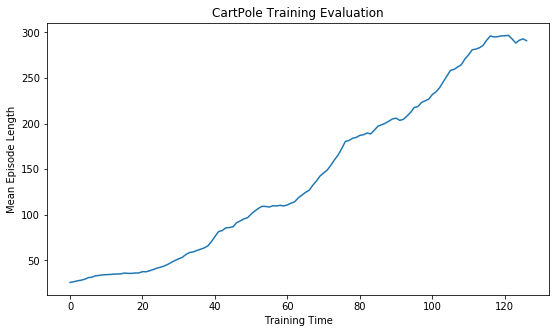

In [81]:
plt.figure(figsize=(9,5))
x = np.array(eplens_)
N = 50
x = np.convolve(x, np.ones((N,))/N, mode='valid')
plt.ylabel("Mean Episode Length")
plt.xlabel("Training Time")
plt.title("CartPole Training Evaluation")
plt.plot(x)
#plt.savefig("avg_rewards_Nstep.pdf")

## Test

In [39]:
steps = 2000
env = gym.make("CartPole-v1")
env.reset()
maxrun = 0
state = torch.from_numpy(env.env.state).float()
done = False
avg_run = 0
runs = int(25)
for i in range(runs):
    maxrun = 0
    done = False
    env.reset()
    state = torch.from_numpy(env.env.state).float()
    while(done==False):
        #env.render('human')
        policy, value = MasterNode(state)
        #sample action
        action = torch.distributions.Categorical(logits=policy.view(-1)).sample().detach().numpy()
        state_, reward, done, lives = env.step(action)
        
        #print(value,reward)
        state = torch.from_numpy(state_).float()
        maxrun += 1
    avg_run += maxrun
avg_run = avg_run / runs
env.close()
print("Maxrun: {}".format(avg_run,))

Maxrun: 383.68


In [14]:
'''TestModel = ActorCritic()
env = gym.make("CartPole-v1")
env.reset()
maxrun = 0
state = torch.from_numpy(env.env.state).float()
done = False
avg_run = 0
runs = int(200)
for i in range(runs):
    maxrun = 0
    done = False
    env.reset()
    state = torch.from_numpy(env.env.state).float()
    while(done==False):
        #env.render('human')
        policy, value = TestModel(state)
        #sample action
        action = torch.distributions.Categorical(logits=policy.view(-1)).sample()
        state_, reward, done, lives = env.step(env.action_space.sample())
        state = torch.from_numpy(state_).float()
        maxrun += 1
    avg_run += maxrun
avg_run /= runs
env.close()
print("Maxrun: {}".format(avg_run,))'''

'TestModel = ActorCritic()\nenv = gym.make("CartPole-v1")\nenv.reset()\nmaxrun = 0\nstate = torch.from_numpy(env.env.state).float()\ndone = False\navg_run = 0\nruns = int(200)\nfor i in range(runs):\n    maxrun = 0\n    done = False\n    env.reset()\n    state = torch.from_numpy(env.env.state).float()\n    while(done==False):\n        #env.render(\'human\')\n        policy, value = TestModel(state)\n        #sample action\n        action = torch.distributions.Categorical(logits=policy.view(-1)).sample()\n        state_, reward, done, lives = env.step(env.action_space.sample())\n        state = torch.from_numpy(state_).float()\n        maxrun += 1\n    avg_run += maxrun\navg_run /= runs\nenv.close()\nprint("Maxrun: {}".format(avg_run,))'

### Demonstrating how bootstrapping reduces variance

In [1]:
r1 = [1,1,-1]
r2 = [1,1,1]
R1,R2 = 0.0,0.0
#No bootstrapping
for i in range(len(r1)-1,0,-1):
    R1 = r1[i] + 0.99*R1
for i in range(len(r2)-1,0,-1):
    R2 = r2[i] + 0.99*R2
print("No bootstrapping")
print(R1,R2)
#With bootstrapping
R1,R2 = 1.0,1.0
for i in range(len(r1)-1,0,-1):
    R1 = r1[i] + 0.99*R1
for i in range(len(r2)-1,0,-1):
    R2 = r2[i] + 0.99*R2
print("With bootstrapping")
print(R1,R2)

No bootstrapping
0.010000000000000009 1.99
With bootstrapping
0.9901 2.9701
